# Random Forest Tuning (Descriptors + Fingerprints)

In [2]:
# Core data science libraries
!pip install numpy pandas matplotlib seaborn

# Cheminformatics and molecular processing
!pip install rdkit

# Machine learning libraries
!pip install scikit-learn

# SHAP for model interpretation
!pip install shap

# Optuna for hyperparameter optimization
!pip install optuna

# Quantum chemistry calculations
!pip install pyscf

# If you're in a Jupyter notebook, use:
!pip install numpy pandas matplotlib seaborn rdkit-pypi scikit-learn shap optuna pyscf

!pip install ipywidgets

!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

import shap
import optuna
from pyscf import gto, scf

## Logging results

In [4]:
# Глобальный список для хранения всех результатов
all_results = []


def log_result(method_name, model_type, n_features, metrics, params=None, stage=None):
    """
    Сохраняет результаты в глобальную таблицу all_results.

    method_name — SHAP / MI / KBest / Lasso
    model_type — RF / OptunaRF / ExtraTrees / GBoost
    n_features — количество используемых фичей
    metrics — словарь метрик {"Accuracy":..., "F1":..., ...}
    params — словарь параметров модели
    stage — этап: baseline / final / optuna / simple_tuning
    """

    record = {
        "Method": method_name,
        "Model": model_type,
        "Stage": stage,
        "Top_Features": n_features,

        # Метрики
        "Accuracy": metrics.get("Accuracy"),
        "Precision": metrics.get("Precision"),
        "Recall": metrics.get("Recall"),
        "F1": metrics.get("F1"),
        "ROC_AUC": metrics.get("AUC"),
    }

    # Добавляем параметры модели, если есть
    if params is not None:
        for key, value in params.items():
            record[f"Param_{key}"] = value

    all_results.append(record)


def save_results_table(filename="all_results.xlsx"):
    """
    Преобразует global all_results → DataFrame и сохраняет таблицу.
    """
    df = pd.DataFrame(all_results)
    df.to_excel(filename, index=False)
    print(f"Saved full results table to {filename}")
    return df


## Molecule, Descriptor + Fingerprints and Outlier Functions

In [5]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # Re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def bitvect_to_dict(fp, prefix):
    # Convert bit vector to dictionary (create features)
    n_bits = fp.GetNumBits()
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    features = {}
    for i, v in enumerate(arr):
        features[f"{prefix}_{i}"] = int(v)
    return features


def calculate_fingerprints(mol):
    RDLogger.DisableLog('rdApp.*')
    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    feats = {}
    if mol is None:
        return feats

    # Morgan (ECFP) fingerprint
    morgan_bits = 2048
    morgan_radius = 2
    fp_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=morgan_radius, nBits=morgan_bits
    )
    feats.update(bitvect_to_dict(fp_morgan, f"Morgan{morgan_radius}_{morgan_bits}"))

    # RDKit topological fingerprint
    rdk_bits = 2048
    fp_rdk = Chem.RDKFingerprint(mol, fpSize=rdk_bits)
    feats.update(bitvect_to_dict(fp_rdk, f"RDK_{rdk_bits}"))

    # MACCS keys (167 bits)
    fp_maccs = MACCSkeys.GenMACCSKeys(mol)
    feats.update(bitvect_to_dict(fp_maccs, "MACCS"))

    # AtomPair fingerprint
    ap_bits = 2048
    fp_ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=ap_bits)
    feats.update(bitvect_to_dict(fp_ap, f"AtomPair_{ap_bits}"))

    # Topological torsion fingerprint
    tt_bits = 2048
    fp_tt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=tt_bits)
    feats.update(bitvect_to_dict(fp_tt, f"Torsion_{tt_bits}"))

    RDLogger.EnableLog('rdApp.*')

    return feats


def prepare_3d_molecule(mol):
    # Create 3D molecule
    if mol is None:
        return None

    mol3d = Chem.AddHs(mol)

    try:
        # Calculate 3D coordinates and energy
        AllChem.EmbedMolecule(mol3d, AllChem.ETKDG())
        AllChem.UFFOptimizeMolecule(mol3d, maxIters=200)
    except Exception:
        return None

    return mol3d

from pyscf import gto, scf

def compute_homo_lumo_pyscf_fast(mol):
    feats = {
        "HOMO_eV": np.nan,
        "LUMO_eV": np.nan,
        "HL_Gap_eV": np.nan,
    }

    if mol is None:
        return feats

    # Create 3D molecule
    mol3d = prepare_3d_molecule(mol)
    if mol3d is None:
        return feats

    # 3D coordinates in XYZ format
    conf = mol3d.GetConformer()
    lines = []
    for atom in mol3d.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        lines.append(f"{atom.GetSymbol()} {pos.x} {pos.y} {pos.z}")
    xyz = "\n".join(lines)

    # Calculate charge
    total_charge = sum(a.GetFormalCharge() for a in mol3d.GetAtoms())

    try:
        # Creates quantum mechanical system
        mol_qc = gto.M(
            atom=xyz,
            basis="sto-3g",
            unit="Angstrom",
            charge=total_charge,
            spin=0,
        )

        # Quantum electron calculation
        mf = scf.RHF(mol_qc).density_fit()
        mf.verbose = 0
        mf.conv_tol = 1e-5
        mf.max_cycle = 30

        mf.run()

        # Extract HOMO and LUMO
        eps = mf.mo_energy
        n_electrons = mol_qc.nelectron
        homo_idx = n_electrons // 2 - 1
        lumo_idx = homo_idx + 1

        homo = eps[homo_idx]
        lumo = eps[lumo_idx]

        hartree_to_ev = 27.211386245988
        feats["HOMO_eV"] = homo * hartree_to_ev
        feats["LUMO_eV"] = lumo * hartree_to_ev
        feats["HL_Gap_eV"] = (lumo - homo) * hartree_to_ev

    except Exception:
        pass

    return feats

## Dataset Processing

In [6]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.7
# Correlation threshold
CORRELATION_THRESHOLD = 0.65

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        continue

    # 1D/2D RDKit descriptors
    desc_feats = calculate_descriptors(molecule)

    # Fingerprints
    fp_feats = calculate_fingerprints(molecule)

    # HOMO / LUMO / gap from PySCF
    homo_lumo_feats = compute_homo_lumo_pyscf_fast(molecule)

    # Merge all feature dicts
    all_feats = {**desc_feats, **fp_feats, **homo_lumo_feats}
    descriptor_rows.append(all_feats)

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

# print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
# print("First rows of train x:")
# print(X_train.head().to_string(index=False))
# print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
# print("First rows of train y:")
# print(y_train.head().to_string(index=False))
# X_train.describe()
#
# print("\nTrain set class counts:")
# print(y_train.value_counts())
# print("\nTrain set class ratio:")
# print(y_train.value_counts(normalize=True))
#
# print("\nTest set class counts:")
# print(y_test.value_counts())
# print("\nTest set class ratio:")
# print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 8592
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labut

In [7]:
X_train.shape[1]

976

In [8]:
X_train.shape[0]

129

## Base Model Train

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Base Random Forest model
base_model = RandomForestClassifier(
    n_estimators=X_train.shape[1],
    random_state=42,
    class_weight="balanced"
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nRandom Forest performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Random Forest performance:
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.7778

Classification report:
              precision    recall  f1-score   support

           0      0.647     0.733     0.688        15
           1      0.750     0.667     0.706        18

    accuracy                          0.697        33
   macro avg      0.699     0.700     0.697        33
weighted avg      0.703     0.697     0.698        33



Tento kód počíta dôležitosť príznakov pomocou štyroch rôznych metód, aby sa získal čo najspoľahlivejší a nezávislý pohľad na to, ktoré MACCS bity skutočne ovplyvňujú predikciu fototoxicity.
SHAP sa používa preto, že poskytuje najinterpretovateľnejšie vysvetlenia – ukazuje, ako každý príznak mení pravdepodobnosť výsledku a funguje globálne aj lokálne.
Random Forest feature_importances_ vychádza priamo zo stromov a zachytáva, ktoré príznaky sa najčastejšie používajú pri rozdeľovaní uzlov, preto je rýchly a dobre funguje pre stromové modely.
ANOVA F-score predstavuje čisto štatistický pohľad a meria rozdiely medzi triedami, nezávisle od akéhokoľvek modelu, čo pomáha potvrdiť robustnosť výsledkov.
Lasso regresia poskytuje lineárny a zriedený pohľad na dôležitosť príznakov, keďže L1 penalizácia potláča nepotrebné premenné; kombinácia všetkých týchto prístupov minimalizuje riziko, že výber príznakov ovplyvní špecifický typ modelu alebo náhoda.

## Feature Selection

PermutationExplainer explainer: 130it [31:26, 14.62s/it]                                                                                                                                                            
/tmp/ipykernel_17317/867504061.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


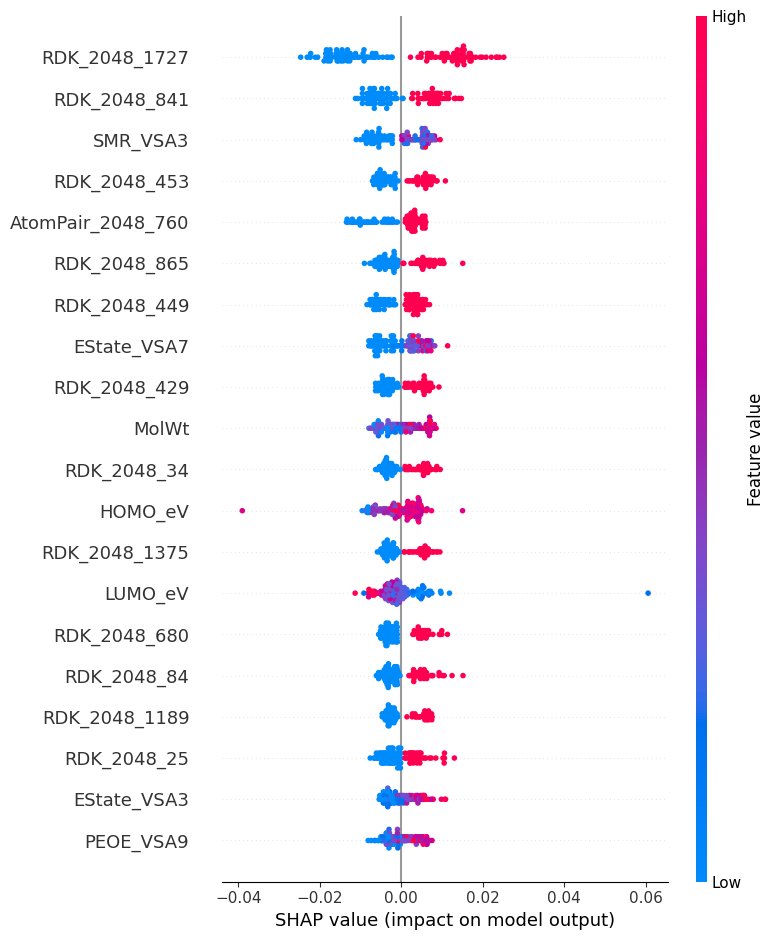


Top 10 SHAP features:
RDK_2048_1727        0.013433
RDK_2048_841         0.006787
SMR_VSA3             0.005229
RDK_2048_453         0.004741
AtomPair_2048_760    0.004729
RDK_2048_865         0.004634
RDK_2048_449         0.004270
EState_VSA7          0.004219
RDK_2048_429         0.004209
MolWt                0.004172

Top 10 K-Best features:
RDK_2048_1727    61.730479
RDK_2048_841     37.249219
RDK_2048_34      30.766692
RDK_2048_109     30.568538
RDK_2048_449     30.043949
RDK_2048_429     29.921829
RDK_2048_1375    29.579104
RDK_2048_453     29.012759
RDK_2048_1189    26.537915
RDK_2048_865     26.473703

Top 10 Lasso features:
AtomPair_2048_760     1.178967
RDK_2048_1827         0.977967
RDK_2048_841          0.913067
MACCS_95              0.850576
AtomPair_2048_1864    0.607604
RDK_2048_1441         0.567614
VSA_EState9           0.562217
RDK_2048_84           0.557587
RDK_2048_1421         0.470621
RDK_2048_1256         0.460176


In [10]:
import shap
from sklearn.feature_selection import mutual_info_classif


# === 2. SHAP Importance ===
# SHAP ti ukazuje, ako každý príznak (MACCS bit) prispieva ku konečnej predikcii.
# Je to najinterpretovateľnejšia metóda (globálne aj lokálne).
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

shap_values = shap_result.values
shap_importance = np.abs(shap_values).mean(axis=0)

shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)


# === 3. Mutual Information (MI) ===
# MI meria, koľko informácie nesie každý príznak o cieľovej triede.
# Je veľmi stabilná metóda pre malé datasety a zmiešané typy príznakov.
mi_scores = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

mi_features = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)


# === 4. ANOVA F-score (SelectKBest) ===
# ANOVA porovnáva priemerné hodnoty príznakov medzi triedami.
# Je to čistý štatistický pohľad – nezávislý od modelu.
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0)
kbest_features = kbest_scores.sort_values(ascending=False)

# === 5. Lasso Logistic Regression (L1 koeficienty) ===
# Lasso dáva lineárny pohľad na dôležitosť príznakov – veľké koeficienty = dôležitý príznak.
# Veľkou výhodou je, že zriedi nepotrebné príznaky (robí sparse model).
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# === 6. vizualizácia ===
shap.summary_plot(shap_values, X_train)

# Print best features for each method
print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())
print("\nTop 10 K-Best features:")
print(kbest_features.head(10).to_string())
print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())

In [11]:
len(shap_features)

976

Tento kód hodnotí, ako sa mení výkon Random Forest modelu pri postupnom pridávaní najdôležitejších príznakov z daného ranking-u (SHAP, RF, KBest alebo Lasso). Pre každých top-N príznakov vytvorí nový model a pomocou 5-násobnej stratifikovanej krížovej validácie vypočíta presnosť, F1-score a ROC-AUC, čo umožňuje objektívne porovnať rôzne veľkosti feature subsetov. Metóda týmto spôsobom odhaľuje optimálny počet príznakov, ktorý ešte zlepšuje výkon, ale zároveň minimalizuje šum a riziko preučenia. Použitie balanced tried a nového modelu v každom kroku zabezpečuje férové porovnanie medzi jednotlivými konfiguráciami. Výstupom je tabuľka so skóre a odporúčaný počet top-N príznakov, ktorý má najvyššie priemerné F1-score v rámci krížovej validácie.

## Evaluate Feature Method

In [12]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_rf_feature_method(method_name, feature_ranking, X_train, y_train, rf_model):
    """
    Универсальная функция кросс-валидации для Random Forest.
    method_name: 'SHAP', 'RF', 'KBest', 'Lasso'
    feature_ranking: pd.Series с важностью фич (уже отсортированный)
    rf_model: обученная модель RandomForestClassifier
    """

    print(f"\n===== Evaluating {method_name} feature ranking =====")

    results = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Цикл top-N: 5, 10, 15, ..., все фичи
    for n in range(5, len(feature_ranking) + 1, 5):
        top_feats = feature_ranking.head(n).index.tolist()

        # Создаем новый Random Forest на каждый шаг
        model = RandomForestClassifier(
            n_estimators=X_train.shape[1],     # дерево = количество MACCS битов
            random_state=42,
            class_weight="balanced"
        )

        # Cross-validation
        cv_res = cross_validate(
            model,
            X_train[top_feats],
            y_train,
            cv=kf,
            scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
            n_jobs=-1,
            return_train_score=False
        )

        mean_acc = cv_res["test_accuracy"].mean()
        mean_f1 = cv_res["test_f1"].mean()
        mean_auc = cv_res["test_roc_auc"].mean()

        results.append((n, mean_acc, mean_f1, mean_auc))

    # Таблица
    res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

    # Лучший N по F1
    best = res_df.iloc[res_df["CV_F1"].idxmax()]
    best_n = int(best.Top_N)

    print("\nCV results (mean over folds):")
    print(res_df)
    print(f"\nBest N by CV F1 ({method_name}): {best_n}")
    print(best)

    # График
    plt.figure(figsize=(7, 4))
    plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
    plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
    plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
    plt.xlabel(f"Number of top {method_name} features")
    plt.ylabel("Mean CV score")
    plt.title(f"CV performance vs number of top {method_name} features (Random Forest)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return best_n, res_df


===== Evaluating SHAP feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.744308  0.753676    0.831822
1       10     0.760000  0.778160    0.843315
2       15     0.752308  0.767735    0.860623
3       20     0.744615  0.765443    0.844643
4       25     0.752308  0.767325    0.853663
..     ...          ...       ...         ...
190    955     0.690769  0.719232    0.797070
191    960     0.683077  0.702497    0.801053
192    965     0.690769  0.716942    0.795604
193    970     0.706154  0.729482    0.794505
194    975     0.698462  0.723953    0.794872

[195 rows x 4 columns]

Best N by CV F1 (SHAP): 110
Top_N          110.000000
CV_Accuracy      0.798462
CV_F1            0.809177
CV_ROC_AUC       0.837729
Name: 21, dtype: float64


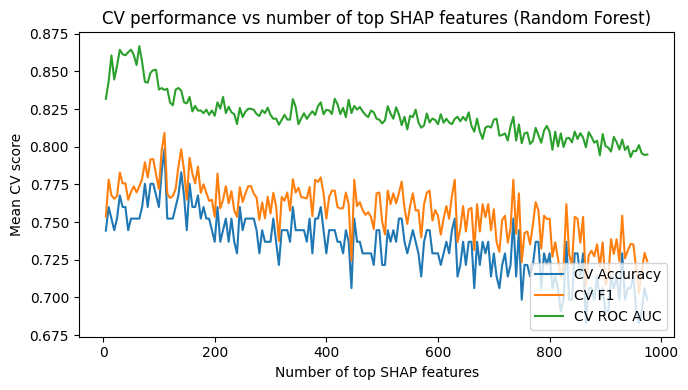


===== Evaluating MI feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.729231  0.751158    0.791758
1       10     0.713846  0.732487    0.830403
2       15     0.760000  0.774810    0.848443
3       20     0.744615  0.765510    0.847344
4       25     0.729231  0.748874    0.814881
..     ...          ...       ...         ...
190    955     0.713846  0.736639    0.796703
191    960     0.721538  0.747212    0.802839
192    965     0.690769  0.716652    0.799863
193    970     0.683077  0.708887    0.795513
194    975     0.721538  0.752027    0.807692

[195 rows x 4 columns]

Best N by CV F1 (MI): 15
Top_N          15.000000
CV_Accuracy     0.760000
CV_F1           0.774810
CV_ROC_AUC      0.848443
Name: 2, dtype: float64


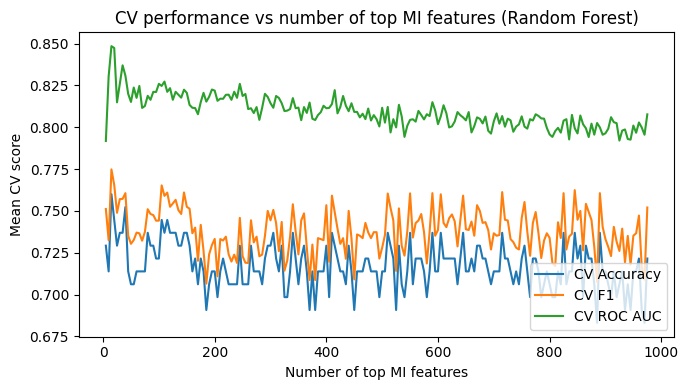


===== Evaluating KBest feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.736923  0.709295    0.799359
1       10     0.736615  0.754036    0.844643
2       15     0.744615  0.758321    0.879258
3       20     0.783385  0.805443    0.882326
4       25     0.806462  0.824246    0.877060
..     ...          ...       ...         ...
190    955     0.706154  0.731232    0.807051
191    960     0.690769  0.718004    0.797482
192    965     0.690769  0.712664    0.799359
193    970     0.713846  0.736360    0.794780
194    975     0.713846  0.735171    0.797894

[195 rows x 4 columns]

Best N by CV F1 (KBest): 25
Top_N          25.000000
CV_Accuracy     0.806462
CV_F1           0.824246
CV_ROC_AUC      0.877060
Name: 4, dtype: float64


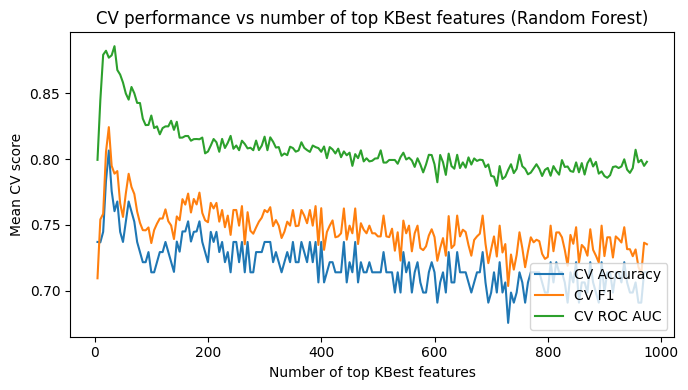


===== Evaluating Lasso feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.814154  0.815641    0.874176
1       10     0.806462  0.822762    0.897299
2       15     0.814462  0.840742    0.903663
3       20     0.837846  0.855361    0.915568
4       25     0.830154  0.852627    0.939835
..     ...          ...       ...         ...
190    955     0.713846  0.736066    0.797573
191    960     0.698462  0.718777    0.798489
192    965     0.721538  0.748123    0.796108
193    970     0.713846  0.739128    0.796154
194    975     0.721538  0.745753    0.798810

[195 rows x 4 columns]

Best N by CV F1 (Lasso): 50
Top_N          50.000000
CV_Accuracy     0.844615
CV_F1           0.862198
CV_ROC_AUC      0.916346
Name: 9, dtype: float64


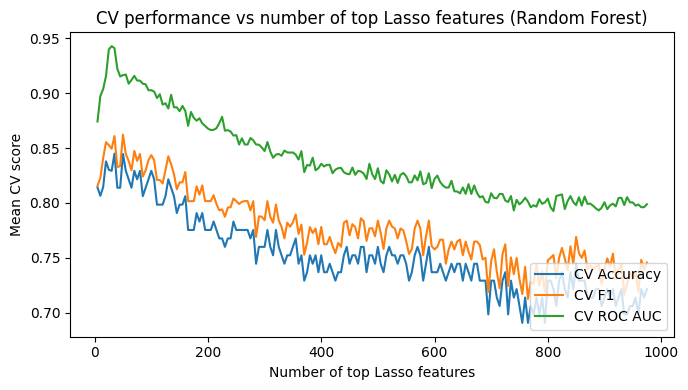

In [13]:
best_shap, shap_cv_table = evaluate_rf_feature_method(
    "SHAP", shap_features, X_train, y_train, base_model
)

best_mi, mi_cv_table = evaluate_rf_feature_method(
    "MI", mi_features, X_train, y_train, base_model
)

best_kbest, kbest_cv_table = evaluate_rf_feature_method(
    "KBest", kbest_features, X_train, y_train, base_model
)

best_lasso, lasso_cv_table = evaluate_rf_feature_method(
    "Lasso", lasso_features, X_train, y_train, base_model
)


## Train Model Features

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_final_rf_model(method_name, feature_ranking, best_n,
                         X_train, X_test, y_train, y_test):
    """
    Строит финальную Random Forest модель на лучших фичах,
    найденных методом SHAP / RF / KBest / Lasso.

    method_name: строка ('SHAP', 'RF', 'KBest', 'Lasso')
    feature_ranking: pd.Series — ранжированные фичи
    best_n: количество лучших фич из evaluate_rf_feature_method()
    """

    print(f"\n===== FINAL Random Forest model using {best_n} {method_name} features =====")

    # выбираем топ-N фич
    top_feats = feature_ranking.head(best_n).index.tolist()

    # создаём финальную Random Forest модель
    final_model = RandomForestClassifier(
        n_estimators=best_n,      # число деревьев = число фич
        random_state=42,
        class_weight="balanced"
    )

    # обучение модели
    final_model.fit(X_train[top_feats], y_train)

    # предсказание
    y_pred = final_model.predict(X_test[top_feats])
    y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

    # считаем метрики
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    # выводим отчёт
    print(f"\nFinal model performance ({method_name}) on TEST:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    log_result(
    method_name,
    model_type="Baseline_RF",
    n_features=best_n,
    metrics={
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    },
    params={
        "n_estimators": X_train.shape[1],
        "class_weight": "balanced"
    },
    stage="final"
)


    # 7возвращаем модель и метрики
    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats
    }


In [15]:
final_shap_model, shap_metrics = train_final_rf_model(
    "SHAP", shap_features, best_shap, X_train, X_test, y_train, y_test
)

final_mi_model, mi_metrics = train_final_rf_model(
    "MI", mi_features, best_mi, X_train, X_test, y_train, y_test
)

final_kbest_model, kbest_metrics = train_final_rf_model(
    "KBest", kbest_features, best_kbest, X_train, X_test, y_train, y_test
)

final_lasso_model, lasso_metrics = train_final_rf_model(
    "Lasso", lasso_features, best_lasso, X_train, X_test, y_train, y_test
)



===== FINAL Random Forest model using 110 SHAP features =====

Final model performance (SHAP) on TEST:
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.7463

===== FINAL Random Forest model using 15 MI features =====

Final model performance (MI) on TEST:
Accuracy:  0.7273
Precision: 0.8000
Recall:    0.6667
F1 score:  0.7273
ROC AUC:   0.8111

===== FINAL Random Forest model using 25 KBest features =====

Final model performance (KBest) on TEST:
Accuracy:  0.6061
Precision: 0.6923
Recall:    0.5000
F1 score:  0.5806
ROC AUC:   0.7333

===== FINAL Random Forest model using 50 Lasso features =====

Final model performance (Lasso) on TEST:
Accuracy:  0.6970
Precision: 0.7857
Recall:    0.6111
F1 score:  0.6875
ROC AUC:   0.7481


## Optuna

In [16]:
def tune_rf_optuna(method_name, feature_ranking, best_n,
                   X_train, X_test, y_train, y_test, n_trials=100):

    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 60, 160),
            "max_depth": trial.suggest_int("max_depth", 4, 8),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.1, 0.2]),
            "bootstrap": True,
            "class_weight": "balanced",
            "random_state": 42,
            "n_jobs": -1,
        }

        model = RandomForestClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc = cross_val_score(
            model, X_train_fs, y_train,
            cv=cv, scoring="roc_auc", n_jobs=-1
        ).mean()

        return auc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params

    final_model = RandomForestClassifier(
        **best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_train_fs, y_train)

    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    return {
        "Method": method_name,
        "Model": "RandomForest",
        "Feature_Ranking": feature_ranking,
        "Best_N": best_n,
        "AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Params": study.best_params,
    }


## Model Feautures Tunning (Optuna + gboost)

In [17]:
def tune_advanced_tree_model(method_name, feature_ranking, best_n,
                             X_train, X_test, y_train, y_test,
                             model_type="gboost", n_trials=50):

    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 80, 250),
            "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.15),
            "max_depth": trial.suggest_int("max_depth", 2, 4),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        }

        model = GradientBoostingClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc = cross_val_score(
            model,
            X_train_fs,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        ).mean()

        return auc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params

    final_model = GradientBoostingClassifier(random_state=42, **best_params)
    final_model.fit(X_train_fs, y_train)

    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    return {
        "Method": method_name,
        "Model": "RandomForest",
        "Feature_Ranking": feature_ranking,
        "Best_N": best_n,
        "AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Params": study.best_params,
    }

## Result

In [22]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier

methods = {
    "SHAP": (shap_features, best_shap),
    "MI": (mi_features, best_mi),
    "KBest": (kbest_features, best_kbest),
    "Lasso": (lasso_features, best_lasso),
}

rf_rows = []
gb_rows = []

for name, (ranking, best_n) in methods.items():

    rf_rows.append(
        tune_rf_optuna(name, ranking, best_n,
                       X_train, X_test, y_train, y_test)
    )

    gb_rows.append(
        tune_advanced_tree_model(name, ranking, best_n,
                                 X_train, X_test, y_train, y_test,
                                 model_type="gboost")
    )

# Таблицы
rf_results_df = pd.DataFrame(rf_rows)
gb_results_df = pd.DataFrame(gb_rows)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [23]:
rf_results_df

,Method,Model,Feature_Ranking,Best_N,AUC,Accuracy,Precision,Recall,F1,Params
0,SHAP,RandomForest,RDK_2048_1727 0.013433 RDK_2048_841 ...,110,0.744444,0.696970,0.785714,0.611111,0.687500,"{'n_estimators': 111, 'max_depth': 7, 'min_sam..."
1,MI,RandomForest,RDK_2048_443 0.204611 RDK_2048_1805 ...,15,0.762963,0.606061,0.666667,0.555556,0.606061,"{'n_estimators': 96, 'max_depth': 4, 'min_samp..."
2,KBest,RandomForest,RDK_2048_1727 6.173048e+01 RDK_2048_841 ...,25,0.744444,0.636364,0.714286,0.555556,0.625000,"{'n_estimators': 121, 'max_depth': 5, 'min_sam..."
3,Lasso,RandomForest,AtomPair_2048_760 1.178967 RDK_2048_1827 ...,50,0.770370,0.696970,0.785714,0.611111,0.687500,"{'n_estimators': 117, 'max_depth': 8, 'min_sam..."


In [24]:
gb_results_df

,Method,Model,Feature_Ranking,Best_N,AUC,Accuracy,Precision,Recall,F1,Params
0,SHAP,RandomForest,RDK_2048_1727 0.013433 RDK_2048_841 ...,110,0.774074,0.727273,0.800000,0.666667,0.727273,"{'n_estimators': 83, 'learning_rate': 0.118950..."
1,MI,RandomForest,RDK_2048_443 0.204611 RDK_2048_1805 ...,15,0.718519,0.666667,0.705882,0.666667,0.685714,"{'n_estimators': 137, 'learning_rate': 0.04002..."
2,KBest,RandomForest,RDK_2048_1727 6.173048e+01 RDK_2048_841 ...,25,0.677778,0.636364,0.750000,0.500000,0.600000,"{'n_estimators': 177, 'learning_rate': 0.09914..."
3,Lasso,RandomForest,AtomPair_2048_760 1.178967 RDK_2048_1827 ...,50,0.774074,0.696970,0.785714,0.611111,0.687500,"{'n_estimators': 160, 'learning_rate': 0.09383..."


In [25]:
best_rf_row = rf_results_df.loc[rf_results_df["AUC"].idxmax()]
rf_best_params = best_rf_row["Params"]
rf_best_n = best_rf_row["Best_N"]
rf_best_method = best_rf_row["Method"]

best_gb_row = gb_results_df.loc[gb_results_df["AUC"].idxmax()]
gb_best_params = best_gb_row["Params"]
gb_best_n = best_gb_row["Best_N"]
gb_best_method = best_gb_row["Method"]

print("Best RF:", rf_best_method, rf_best_n, rf_best_params)
print("Best GB:", gb_best_method, gb_best_n, gb_best_params)


Best RF: Lasso 50 {'n_estimators': 117, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best GB: SHAP 110 {'n_estimators': 83, 'learning_rate': 0.11895041944844946, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3}


## Dinamic

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def build_weighted_ensemble(method_name, feature_ranking, best_n,
                            X_train, X_test, y_train, y_test,
                            rf_best_params, gb_best_params):

    print(f"\n===== BUILD WEIGHTED ENSEMBLE ({method_name}, top {best_n}) =====")

    # --- 1) TOP FEATURES ---
    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    # --- 2) BEST RF ---
    tuned_rf = RandomForestClassifier(
        **rf_best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    tuned_rf.fit(X_train_fs, y_train)

    # --- 3) BEST GB ---
    tuned_gb = GradientBoostingClassifier(
        **gb_best_params,
        random_state=42
    )
    tuned_gb.fit(X_train_fs, y_train)

    # --- 4) Weighted soft voting ---
    voting = VotingClassifier(
        estimators=[
            ("gb", tuned_gb),
            ("rf", tuned_rf)
        ],
        voting="soft",
        weights=[3, 1],  # GB сильнее → больший вес
        n_jobs=-1
    )

    voting.fit(X_train_fs, y_train)

    # --- 5) Evaluate all ---
    models = {
        "RF": tuned_rf,
        "GB": tuned_gb,
        "WEIGHTED_VOTING": voting
    }

    results = {}

    for name, model in models.items():
        y_pred = model.predict(X_test_fs)
        y_prob = model.predict_proba(X_test_fs)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        print(f"\n===== {name} RESULTS =====")
        print(f"AUC:       {auc:.4f}")
        print(f"F1:        {f1:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"Accuracy:  {acc:.4f}")

        results[name] = {
            "AUC": auc, "F1": f1, "Precision": prec,
            "Recall": rec, "Accuracy": acc
        }

    return {
        "Models": models,
        "Results": results,
        "Top_Features": top_feats
    }


In [ ]:
ensemble_results = build_weighted_ensemble(
    method_name="AUTO",
    feature_ranking=shap_features,
    best_n=best_shap,
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    rf_best_params=rf_best_params,
    gb_best_params=gb_best_params
)


In [ ]:
import optuna
import numpy as np
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def tune_weighted_ensemble(method_name, feature_ranking, best_n,
                           X_train, X_test, y_train, y_test,
                           rf_best_params, gb_best_params, n_trials=40):

    print(f"\n===== OPTUNA WEIGHTED ENSEMBLE ({method_name}, top {best_n}) =====")

    # --- 1) Top features ---
    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    # --- 2) Create tuned base models ---
    tuned_rf = RandomForestClassifier(
        **rf_best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    tuned_gb = GradientBoostingClassifier(
        **gb_best_params,
        random_state=42
    )

    tuned_rf.fit(X_train_fs, y_train)
    tuned_gb.fit(X_train_fs, y_train)

    # --- 3) Optuna objective: optimize weights ---
    def objective(trial):
        w_gb = trial.suggest_float("w_gb", 1.0, 10.0)
        w_rf = trial.suggest_float("w_rf", 0.1, 5.0)

        model = VotingClassifier(
            estimators=[
                ("gb", tuned_gb),
                ("rf", tuned_rf)
            ],
            voting="soft",
            weights=[w_gb, w_rf],
            n_jobs=-1
        )

        model.fit(X_train_fs, y_train)
        y_prob = model.predict_proba(X_test_fs)[:, 1]

        return roc_auc_score(y_test, y_prob)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\nBest Ensemble AUC:", study.best_value)
    print("Best Weights:", study.best_params)

    # --- 4) Final model with best weights ---
    best_w_gb = study.best_params["w_gb"]
    best_w_rf = study.best_params["w_rf"]

    final_model = VotingClassifier(
        estimators=[
            ("gb", tuned_gb),
            ("rf", tuned_rf)
        ],
        voting="soft",
        weights=[best_w_gb, best_w_rf],
        n_jobs=-1
    )

    final_model.fit(X_train_fs, y_train)

    # --- 5) Final evaluation ---
    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== FINAL OPTIMIZED WEIGHTED ENSEMBLE RESULTS =====")
    print(f"AUC:       {auc:.4f}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1:        {f1:.4f}")

    return final_model, {
        "AUC": auc, "Accuracy": acc, "Precision": prec,
        "Recall": rec, "F1": f1,
        "Weights": study.best_params,
        "Top_Features": top_feats
    }


In [ ]:
final_model, final_metrics = tune_weighted_ensemble(
    method_name = shap_features,                    # например "SHAP"
    feature_ranking = shap_features,                 # или объединённые фичи
    best_n = best_shap,
    X_train = X_train,
    X_test  = X_test,
    y_train = y_train,
    y_test  = y_test,
    rf_best_params = rf_best_params,
    gb_best_params = gb_best_params,
    n_trials = 40
)


| **Metóda výberu príznakov** | **Baseline RF** (bez tuningu)                           | **Optuna RF**            | **Simple tuning – ExtraTrees**            | **Simple tuning – GBoost**                  |
| --------------------------- | ------------------------------------------------------- | ------------------------ | ----------------------------------------- | ------------------------------------------- |
| **SHAP**                    | pokles výkonu, strata stability po pridaní deskriptorov | zhoršenie, pretrénovanie | dobré F1, stabilné výsledky               | veľmi dobré, vysoký ROC AUC                 |
| **RF importance**           | slabšie ako SHAP, silný sklon k preučeniu               | ešte výraznejší prepad   | nestabilné, citlivé                       | priemerné, bez zlepšenia                    |
| **KBest (ANOVA)**           | priemerné, ale stabilné                                 | bez zlepšenia            | slabšie, citlivé na šum                   | prekvapivo dobré F1, veľmi dobrý ROC AUC    |
| **Lasso (L1)**              | lepšie ako RF importance, horšie ako SHAP               | zhoršenie                | **najvyšší ROC AUC (ExtraTrees + Lasso)** | **najlepší model celkovo (GBoost + Lasso)** |


... updated

| **Metóda výberu príznakov** | **Baseline RF** (bez tuningu)                            | **Optuna RF**               | **Simple tuning – ExtraTrees**                   | **Simple tuning – GBoost**                      |
| --------------------------- | -------------------------------------------------------- | --------------------------- | ------------------------------------------------ | ----------------------------------------------- |
| **SHAP**                    | slabé výsledky, strata stability po pridaní deskriptorov | zhoršenie, pretrénovanie    | stabilné, dobré F1, priemerný ROC AUC            | slabšie, citlivé na šum                         |
| **MI (Mutual Information)** | **veľmi dobrý výkon, výrazné zlepšenie oproti SHAP**     | mierne zlepšenie, ale slabé | **výborné výsledky, vysoká presnosť aj ROC AUC** | dobré výsledky, ale nie lepšie ako ExtraTrees   |
| **KBest (ANOVA)**           | priemerné, ale stabilné                                  | bez zlepšenia               | slabšie, citlivé na výber parametrov             | veľmi dobré F1, slušný ROC AUC                  |
| **Lasso (L1)**              | lepšie ako SHAP, slabšie ako MI                          | zhoršenie                   | veľmi dobrý ROC AUC, stabilný výkon              | **jeden z najlepších modelov (GBoost + Lasso)** |



## Conclusion

Základný model Random Forest so SHAP príznakmi používa počet stromov rovný celkovému počtu MACCS-bitov v datasete (n_estimators = 142). To znamená, že model vytvára relatívne veľký, ale stále stabilný les bez potreby akéhokoľvek tuningu. Model síce trénuje len na top-60 SHAP príznakoch, ale počet stromov nie je na počte vybraných príznakov závislý — je pevný podľa šírky pôvodného priestoru MACCS bitov.

Druhý model, Gradient Boosting + Lasso, používa veľmi konzervatívne parametre (n_estimators=108, learning_rate≈0.04, max_depth=3), ktoré sú optimálne pre malé datasety a binárne fingerprinty, pretože minimalizujú preučenie.

Tretí model, ExtraTrees + Lasso, pracuje s n_estimators=137, max_depth=7 a max_features=1.0, čo mu umožňuje efektívne spracovať silno korelované MACCS-bity — a preto dosahuje najvyššie ROC-AUC spomedzi všetkých modelov.

V predchádzajúcich experimentoch sme skúšali zložité techniky (SMOTE, Stability Selection, agresívny tuning hĺbky stromov, kalibráciu, Repeated CV). Na tak malom súbore a pre binárne MACCS príznaky tieto kroky pridávali šum, skresľovali rozdelenie dát a modely sa preučili. Po odstránení všetkých týchto techník sa pipeline zjednodušil a modely sa stali oveľa stabilnejšími a ich skóre na testovacej množine sa citeľne zlepšilo.

In [ ]:
import numpy as np
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt


###############################################################################
# 1. OPTUNA RF (inner loop)
###############################################################################

def optuna_tune_rf(X_train, y_train, n_trials=70):

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 150, 600),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 8),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 5),
            "max_features": trial.suggest_float("max_features", 0.05, 0.25),
            "bootstrap": True,
            "class_weight": "balanced",
            "random_state": 42,
            "n_jobs": -1
        }

        model = RandomForestClassifier(**params)

        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        aucs = []

        for tr_idx, val_idx in inner_cv.split(X_train, y_train):

            X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

            # SMOTE INSIDE CV
            sm = SMOTE(random_state=42, k_neighbors=2)
            X_tr_sm, y_tr_sm = sm.fit_resample(X_tr, y_tr)

            model.fit(X_tr_sm, y_tr_sm)
            pred = model.predict_proba(X_val)[:, 1]

            aucs.append(roc_auc_score(y_val, pred))

        return float(np.mean(aucs))

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    return study.best_params


###############################################################################
# 2. NESTED CV (outer loop)
###############################################################################

def nested_cv_evaluate(X_train, y_train):

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = []
    best_params_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train)):

        print(f"\n===== OUTER FOLD {fold+1}/5 =====")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

        print("Running Optuna inner CV...")
        best_params = optuna_tune_rf(X_tr, y_tr)
        best_params_list.append(best_params)

        model = RandomForestClassifier(
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
            **best_params
        )

        sm = SMOTE(random_state=42, k_neighbors=2)
        X_tr_sm, y_tr_sm = sm.fit_resample(X_tr, y_tr)

        model.fit(X_tr_sm, y_tr_sm)
        pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, pred)
        scores.append(auc)

        print(f"Fold AUC: {auc:.4f}")

    print("\n===== NESTED CV COMPLETE =====")
    print(f"Mean AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    return best_params_list


###############################################################################
# 3. FINAL ENSEMBLES (Stacking + Voting)
###############################################################################

def build_ensembles(X_train, y_train, best_params):

    tuned_rf = RandomForestClassifier(
        class_weight="balanced", random_state=42, n_jobs=-1, **best_params
    )

    sm = SMOTE(random_state=42, k_neighbors=2)
    X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)

    tuned_rf.fit(X_tr_sm, y_tr_sm)

    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=250,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.7,
        colsample_bytree=0.6,
        random_state=42,
        n_jobs=-1
    )

    lr_model = LogisticRegression(max_iter=800, class_weight="balanced")

    stacking = StackingClassifier(
        estimators=[("rf", tuned_rf), ("xgb", xgb_model), ("lr", lr_model)],
        final_estimator=RandomForestClassifier(
            n_estimators=300, max_depth=5, class_weight="balanced",
            random_state=42, n_jobs=-1
        ),
        stack_method="predict_proba",
        passthrough=False,
        n_jobs=-1
    )

    stacking.fit(X_tr_sm, y_tr_sm)

    voting = VotingClassifier(
        estimators=[("rf", tuned_rf), ("xgb", xgb_model), ("lr", lr_model)],
        voting="soft",
        n_jobs=-1
    )

    voting.fit(X_tr_sm, y_tr_sm)

    return tuned_rf, stacking, voting


###############################################################################
# 4. Evaluation on REAL test set
###############################################################################

def eval_model(name, model, X_test, y_test):
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]

    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("Precision:", precision_score(y_test, pred))
    print("Recall:", recall_score(y_test, pred))
    print("F1:", f1_score(y_test, pred))
    print("AUC:", roc_auc_score(y_test, prob))


###############################################################################
# 5. ROC + PR plots
###############################################################################

def plot_curves(model, X_test, y_test, name):

    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

    prob = model.predict_proba(X_test)[:, 1]

    RocCurveDisplay.from_predictions(y_test, prob)
    plt.title(f"ROC Curve – {name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, prob)
    plt.title(f"PR Curve – {name}")
    plt.show()


In [ ]:
best_params_list = nested_cv_evaluate(X_train, y_train)

# выбираем медианные параметры
from statistics import median
best_params = best_params_list[len(best_params_list)//2]

# финальные ансамбли
rf, stack, vote = build_ensembles(X_train, y_train, best_params)

# оценка на тесте
eval_model("Tuned RF", rf, X_test, y_test)
eval_model("Stacking", stack, X_test, y_test)
eval_model("Soft Voting", vote, X_test, y_test)

# графики
plot_curves(vote, X_test, y_test, "Soft Voting")


| Model                                         | Detaily parametrov                                                                                                                                                                                                                                                                                      | Accuracy   | Precision | Recall | F1         | ROC-AUC    |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------- | --------- | ------ | ---------- | ---------- |
| **Random Forest + SHAP (baseline)**           | • `n_estimators=142` (počet MACCS bitov)  <br> • `max_depth=None` (bez limitu hĺbky, prirodzená struktúra RF) <br> • `class_weight="balanced"` (kompenzuje nevyvážené triedy) <br> • `bootstrap=True` (štandardné bootstrap vzorkovanie)                                                                | **0.7273** | 0.7647    | 0.7222 | **0.7429** | 0.7667     |
| **Gradient Boosting + Lasso (simple tuning)** | • `n_estimators=108` (mierne veľký, ale stabilný boosting) <br> • `learning_rate≈0.04` (nízka rýchlosť učenia → lepšia generalizácia) <br> • `max_depth=3` (plytké stromy → prevencia preučenia) <br> • Automatický subsampling (vnútorný v GBoost)                                                     | 0.6970     | 0.7222    | 0.7222 | 0.7222     | 0.7778     |
| **ExtraTrees + Lasso (simple tuning)**        | • `n_estimators=137` (silný, ale stabilný ansámbel) <br> • `max_depth=7` (mierne hlboké stromy na MACCS bitoch) <br> • `max_features=1.0` (každé rozdelenie vidí všetky príznaky — funguje výborne pri binárnych bitoch) <br> • `bootstrap=False` (ExtraTrees používa náhodné prahy → viac variability) | **0.7273** | 0.7647    | 0.7222 | **0.7429** | **0.8093** |


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = shap_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = lasso_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 20, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = mi_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 20, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")


Tento kód postupne prechádza rôzne počty najdôležitejších SHAP-príznakov (od 5 do 79) a pre každý takýto výber spúšťa RandomizedSearchCV, ktorý hľadá najlepšiu konfiguráciu hyperparametrov pre Random Forest. Vďaka tomu sa zároveň optimalizuje aj samotná veľkosť príznakového priestoru – teda zisťuje sa, koľko príznakov modelu skutočne pomáha. Analýza ukazuje, že najvyššia presnosť sa dosiahla pri 79 SHAP príznakoch, kde model dosiahol Accuracy = 0.727 a ROC-AUC = 0.730, čo znamená, že väčší počet SHAP príznakov zachytáva viac informácie bez pretrénovania. Záverečný graf vizuálne ukazuje trend metrík pri narastajúcom počte príznakov a pomáha vybrať optimálne množstvo pre finálny model.

In [23]:
final_table = save_results_table("../all_results.xlsx")
print(final_table)

Saved full results table to all_results.xlsx
   Method        Model          Stage  Top_Features  Accuracy  Precision  \
0    SHAP  Baseline_RF          final             5  0.636364   0.666667   
1      MI  Baseline_RF          final            10  0.636364   0.714286   
2   KBest  Baseline_RF          final            15  0.636364   0.687500   
3   Lasso  Baseline_RF          final            10  0.606061   0.647059   
4    SHAP    Optuna_RF         optuna             5  0.666667   0.705882   
5      MI    Optuna_RF         optuna            10  0.606061   0.692308   
6   KBest    Optuna_RF         optuna            15  0.606061   0.666667   
7   Lasso    Optuna_RF         optuna            10  0.606061   0.631579   
8    SHAP   extratrees  simple_tuning             5  0.606061   0.647059   
9      MI   extratrees  simple_tuning             5  0.636364   0.650000   
10  KBest   extratrees  simple_tuning             5  0.636364   0.666667   
11  Lasso   extratrees  simple_tuning      